# Applying ML to Berlin metro dataset

by Tom Fenske

### 1. Importing Libraries and Dataset

In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import folium
import json 
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print('Libraries successfully imported')

Libraries successfully imported


In [2]:
#Import dataset
df_metro=pd.read_csv('../../II_Datasets/Berlin_metro.csv')
print('Done')

Done


In [3]:
df_metro.head()

,Unnamed: 0,Station,lat,lon
0,0,Adlershof,52.434722,13.541389
1,1,Ahrensfelde,52.571667,13.565000
2,2,Albrechtshof,52.549444,13.128333
3,3,Alexanderplatz,52.521389,13.411944
4,4,Alt-Reinickendorf,52.577778,13.350556


In [4]:
df_metro.drop('Unnamed: 0', axis=1, inplace=True)
df_metro.head()

,Station,lat,lon
0,Adlershof,52.434722,13.541389
1,Ahrensfelde,52.571667,13.565000
2,Albrechtshof,52.549444,13.128333
3,Alexanderplatz,52.521389,13.411944
4,Alt-Reinickendorf,52.577778,13.350556


In [5]:
df_metro.shape

(172, 3)

### Creating Foursquare API call to retrieve venues around the stations

In [36]:
#API Credentials
client_ID = 'LEU5OIAP31MI5JXX1M4LGWJNMMPHZWTKHQD3W5A34FGSDPY0'
client_secret = '0EKHGNCNUD014O4USGZ03ZDFXQQEDNEHOMP0OJQSGBIDAMEY'
version='20200801'
radius=1500
limit=50
lat=52.520008
lon=13.404954


In [37]:
#URL to call API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    client_ID, 
    client_secret, 
    version, 
    lat, 
    lon, 
    radius, 
    limit)

In [38]:
#Defining API call for nearby venues around the coordinates of each station

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        #URL to call API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_ID, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
#Calling the API with the Toronto dataframe

Station_venues = getNearbyVenues(names=df_metro['Station'],
                                   latitudes=df_metro['lat'],
                                   longitudes=df_metro['lon']
                                  )



Adlershof
Ahrensfelde
Albrechtshof
Alexanderplatz
Alt-Reinickendorf
Altglienicke
Anhalter Bahnhof
Attilastraße
Babelsberg
Baumschulenweg
Bellevue
Bergfelde 
Bernau 
Bernau-Friedenstal
Betriebsbahnhof Rummelsburg
Betriebsbahnhof Schöneweide
Beusselstraße
Biesdorf
Birkenstein
Birkenwerder 
Blankenburg
Blankenfelde 
Borgsdorf
Bornholmer Straße
Botanischer Garten
Brandenburger Tor
Buch
Buckower Chaussee
Bundesplatz
Charlottenburg
Dahlewitz
Dreilinden
Düppel
Eichborndamm
Eichkamp
Eichwalde
Erkner
Falkensee
Feuerbachstraße
Flughafen Berlin-Brandenburg
Flughafen Berlin-Schönefeld
Frankfurter Allee
Fredersdorf 
Friedenau
Friedrichsfelde Ost
Friedrichshagen
Friedrichstraße
Frohnau
Gartenfeld
Gehrenseestraße
Gesundbrunnen
Greifswalder Straße
Griebnitzsee
Grünau
Grünbergallee
Grunewald
Hackescher Markt
Halensee
Hauptbahnhof
Heerstraße
Hegermühle
Heidelberger Platz
Heiligensee
Hennigsdorf 
Hennigsdorf Nord
Hermannstraße
Hermsdorf
Hirschgarten
Hohen Neuendorf 
Hohenschönhausen
Hohenschöpping
Hohenz

In [40]:
Station_venues.shape

(5673, 7)

In [41]:
Station_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adlershof,52.434722,13.541389,Olympia Greek Food,52.433982,13.538500,Greek Restaurant
1,Adlershof,52.434722,13.541389,Griechisches Restaurant Athen,52.434901,13.546680,Greek Restaurant
2,Adlershof,52.434722,13.541389,Mia Toscana,52.438327,13.549573,Italian Restaurant
3,Adlershof,52.434722,13.541389,Food - Taste of the world on the road,52.428786,13.538168,Food Truck
4,Adlershof,52.434722,13.541389,mani mogo,52.432893,13.531991,Korean Restaurant


In [42]:
print('There are {} uniques categories.'.format(len(Station_venues['Venue Category'].unique())))

There are 364 uniques categories.


In [43]:
print('There are {} uniques stations.'.format(len(Station_venues['Station'].unique())))

There are 172 uniques stations.


In [44]:
# Applying One-Hot-Encoding in preparation of kmeans method
Station_onehot = pd.get_dummies(Station_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
Station_onehot['Station'] = Station_venues['Station'] 

# move neighbourhood column to the first column
fixed_columns = [Station_onehot.columns[-1]] + list(Station_onehot.columns[:-1])
Station_onehot = Station_onehot[fixed_columns]

Station_onehot.head()

,Station,ATM,Adult Boutique,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Adlershof,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adlershof,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adlershof,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adlershof,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adlershof,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
Station_onehot.shape

(5673, 365)

In [46]:
#Grouping the venues of each neigbourhood
Station_grouped = Station_onehot.groupby('Station').mean().reset_index()
Station_grouped

,Station,ATM,Adult Boutique,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
1,Ahrensfelde,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
2,Albrechtshof,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
3,Alexanderplatz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
4,Alt-Reinickendorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Zehlendorf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.020408,0.00,0.00
168,Zehlendorf Süd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.023810,0.00,0.00
169,Zepernick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00
170,Zeuthen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.00


In [47]:
Station_grouped.shape

(172, 365)

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Station_venues_sorted = pd.DataFrame(columns=columns)
Station_venues_sorted['Station'] = Station_grouped['Station']

for ind in np.arange(Station_grouped.shape[0]):
    Station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Station_grouped.iloc[ind, :], num_top_venues)

Station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Supermarket,Café,Hotel,Drugstore,Bank,Greek Restaurant,Italian Restaurant,Tram Station,Park,Sushi Restaurant
1,Ahrensfelde,Supermarket,Tram Station,Skate Park,Animal Shelter,Soccer Field,Train Station,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant
2,Albrechtshof,Train Station,Supermarket,Bus Stop,Greek Restaurant,Lake,Thai Restaurant,Trattoria/Osteria,Automotive Shop,Furniture / Home Store,Photography Studio
3,Alexanderplatz,Hotel,Vietnamese Restaurant,Bookstore,Coffee Shop,Clothing Store,Indie Movie Theater,Optical Shop,Café,Gym / Fitness Center,Theater
4,Alt-Reinickendorf,Supermarket,Bus Stop,Bakery,Park,Metro Station,Turkish Restaurant,Market,Doner Restaurant,Light Rail Station,Gastropub


In [99]:
# set number of clusters
kclusters = 5

Station_grouped_clustering = Station_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Station_grouped_clustering)


# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([1, 3, 0, 1, 0, 3, 1, 0, 0, 0, 1, 4, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 3, 1, 0, 3, 0, 1,
       0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 0, 0, 0, 1, 1, 3, 0, 1, 0,
       0, 3, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1, 0, 0,
       1, 1, 1, 0, 3, 0, 1, 1, 3, 1, 0, 1, 0, 4, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 0, 4, 1,
       1, 1, 1, 1, 0, 4, 0, 0, 1, 3, 0, 1, 1, 1, 1, 3, 0, 1])

--------------------------------

--------------------------

In [100]:
# Add Cluster values to dataframe
Station_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Station_venues_sorted.dropna()
Station_merged = df_metro

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Station_merged = Station_merged.join(Station_venues_sorted.set_index('Station'), on='Station')

Station_merged.head() 

,Station,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,52.434722,13.541389,1,Supermarket,Café,Hotel,Drugstore,Bank,Greek Restaurant,Italian Restaurant,Tram Station,Park,Sushi Restaurant
1,Ahrensfelde,52.571667,13.565000,3,Supermarket,Tram Station,Skate Park,Animal Shelter,Soccer Field,Train Station,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant
2,Albrechtshof,52.549444,13.128333,0,Train Station,Supermarket,Bus Stop,Greek Restaurant,Lake,Thai Restaurant,Trattoria/Osteria,Automotive Shop,Furniture / Home Store,Photography Studio
3,Alexanderplatz,52.521389,13.411944,1,Hotel,Vietnamese Restaurant,Bookstore,Coffee Shop,Clothing Store,Indie Movie Theater,Optical Shop,Café,Gym / Fitness Center,Theater
4,Alt-Reinickendorf,52.577778,13.350556,0,Supermarket,Bus Stop,Bakery,Park,Metro Station,Turkish Restaurant,Market,Doner Restaurant,Light Rail Station,Gastropub


In [101]:
# create map
Berlin_lat=52.520008
Berlin_lon=13.404954

map_clusters = folium.Map(location=[Berlin_lat, Berlin_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(Station_merged['lat'], Station_merged['lon'], Station_merged['Station'], Station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       

#map_clusters.save('Berlin_metro_k=8.html')
map_clusters

### Interpretation of Clusters 

In [102]:
#Cluster 1: residential
for n in range (0,kclusters):
    Cluster = Station_merged.loc[Station_merged['Cluster Labels'] == n, 
                               Station_merged.columns[[0] + list(range(3, Station_merged.shape[1]))]]

    print('The number of stations in Cluster ' + str(n) +  ' is ' + str(Cluster.shape[0]))
    print(' ')
    path='../../IV_Output files/'+'Cluster'+str(n)+'_k='+str(kclusters)+'.xlsx'
    Cluster.to_excel(path)
    print('------------Next Cluster------------')


The number of stations in Cluster 0 is 59
 
------------Next Cluster------------
The number of stations in Cluster 1 is 89
 
------------Next Cluster------------
The number of stations in Cluster 2 is 1
 
------------Next Cluster------------
The number of stations in Cluster 3 is 18
 
------------Next Cluster------------
The number of stations in Cluster 4 is 5
 
------------Next Cluster------------


In [ ]:
#k=2
#cluster 0:
#cluster 1:



In [ ]:
#k=5
#cluster 0
#cluster 1: 
#cluster 2: 
#cluster 3: 
#cluster 4: 



In [92]:
#k=8
#cluster 0: rural/industrial
#cluster 1: residential
#cluster 2: residential/tourist
#cluster 3: residential
#cluster 4: tourist
#cluster 5: commercial/industrial
#cluster 6: 
#cluster 7:rural


###### Elbow method to find the best k

In [65]:
#Elbow method
distortions = []
K = range(1,16)
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Station_grouped_clustering)
    distortions.append(kmeans.inertia_)

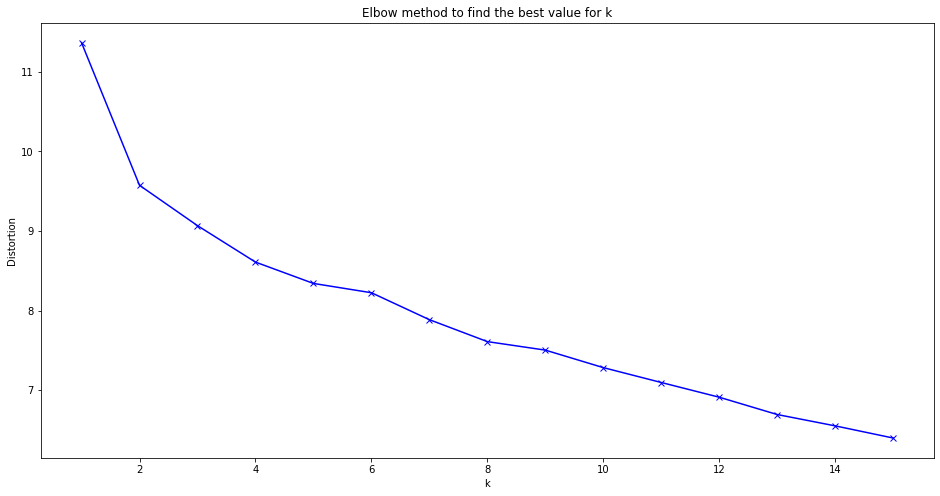

In [67]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method to find the best value for k')
plt.show()